In [146]:
import os
import operator
from dotenv import load_dotenv
from typing import Annotated, List, Optional, Dict
from typing_extensions import TypedDict
from IPython.display import Image, Markdown

from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool


load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="llama3-70b-8192", api_key = groq_api_key)


In [147]:
class TripRequest(BaseModel) :
    """Schema for user's travel requests."""
    destination : str = Field(description= "The city or country for the trip.")
    days : int = Field(description= "The total number of days for the trip.")
    person : int = Field(description= "The total number of person who participate the trip")
    budget : Optional[float] = Field(description= "The estimated budget for the trip") 
    interests : Optional[List[str]] = Field(description= "A list of interests for the trip, e.g., []'art', 'history', 'food']." )
    

In [148]:
class FlightInfo(BaseModel) :
    """Schema for flight information"""
    airline : str = Field(description= "The name of the airline")
    price : float = Field(description= "The price of the round-trip flight")
    origin : str = Field(description= "The departure city")
    destination : str = Field(description= "The arrival city")


class HotelInfo(BaseModel):
    """Schema for hotel information."""
    hotel_name: str = Field(description="The name of the hotel.")
    price_per_night: float = Field(description="The price per night.")
    total_price: float = Field(description="The total price for the entire stay.")
    rating: float = Field(description="The hotel's rating out of 5.")


class Activity(BaseModel):
    """Schema for a single activity."""
    name: str = Field(description="Name of the activity or place.")
    description: str = Field(description="A brief description of the activity.")
    location: str = Field(description="Location or address of the activity.")
    time_of_day: str = Field(description="Suggested time of day, e.g., 'Morning', 'Afternoon', 'Evening'.")


class DailyPlan(BaseModel):
    """Schema for a single day's plan."""
    day: int = Field(description="The day number (e.g., 1, 2, 3).")
    activities: List[Activity] = Field(description="A list of activities for the day.")



class Itinerary(BaseModel):
    """The complete, final itinerary for the trip."""
    flight_info: FlightInfo
    hotel_info: HotelInfo
    daily_plans: List[DailyPlan]

In [149]:
@tool
def flight_search_tool(destination: str, person: int) -> FlightInfo:
    """
    Searches for flights for a given destination and number of persons.
    This is a mock tool and returns dummy data.
    """
    print(f"--- Calling Flight Search Tool for {destination} for {person} people ---")
    
    base_price_per_person = 750.0
    total_price = base_price_per_person * person
    
    return FlightInfo(
        airline="Turkish Airlines",
        price=total_price,
        origin="Antalya",
        destination=destination
    )


@tool
def hotel_search_tool(destination: str, days: int, person: int) -> HotelInfo:
    """
    Searches for hotels for a given destination, duration, and number of people.
    This is a mock tool and returns dummy data.
    """
    print(f"--- Calling Hotel Search Tool for {destination} for {person} people ---")
    price_per_night = 150.0 * (person / 2) 
    total_price = price_per_night * (days - 1) 
    return HotelInfo(hotel_name="Grand Royale Hotel", price_per_night=price_per_night, total_price=total_price, rating=4.5)



@tool
def activity_finder_tool(destination: str, interests: List[str]) -> List[Dict]:
    """Finds local activities based on destination and interests."""
    print(f"--- Calling Activity Finder Tool for {destination} with interests: {interests} ---")
   
    activities = {
        "history": [{"name": "Colosseum", "description": "Ancient Roman amphitheater.", "location": "Piazza del Colosseo, 1"},
                    {"name": "Roman Forum", "description": "Ruins of ancient government buildings.", "location": "Via della Salara Vecchia, 5/6"}],
        "food": [{"name": "Trastevere Food Tour", "description": "Explore local eateries and taste authentic Roman food.", "location": "Trastevere neighborhood"},
                 {"name": "Pizza Making Class", "description": "Learn to make classic Italian pizza.", "location": "Central Rome"}],
        "art": [{"name": "Vatican Museums", "description": "Home to masterpieces of painting, sculpture.", "location": "Vatican City"},
                {"name": "Borghese Gallery", "description": "A gallery housing a substantial part of the Borghese collection of paintings.", "location": "Piazzale Scipione Borghese, 5"}]
    }
    results = []
    for interest in interests:
        if interest.lower() in activities:
            results.extend(activities[interest.lower()])
    return results

In [150]:
class TripState(TypedDict):
    user_request: str
    trip_plan: Optional[TripRequest]
    flight_info: Optional[FlightInfo]
    hotel_info: Optional[HotelInfo]
    final_itinerary: Optional[Itinerary]

In [151]:
def planner_agent(state: TripState) -> dict:
    """
    Takes the user request and converts it into a structured TripRequest object.
    """
    print("--- Running Planner Agent ---")
    
    structured_llm = llm.with_structured_output(TripRequest)
    
    prompt = f"""
    Parse the following user request into a structured TripRequest object.
    Identify the destination, number of days, budget, and key interests.

    User Request: "{state['user_request']}"
    """
    
    plan = structured_llm.invoke(prompt)
    print(f"-> Structured Plan: {plan}")
    
    return {"trip_plan": plan}

In [152]:
def flight_agent(state: TripState) -> dict:
    """
    Takes the structured trip plan and uses the flight search tool to find flights.
    """
    print("--- Running Flight Agent ---")
    trip_plan = state['trip_plan']
    if not trip_plan:
        return {}


    flight_data = flight_search_tool.invoke({
        "destination": trip_plan.destination,
        "person": trip_plan.person
    })
    print(f"-> Flight Info: {flight_data}")

    return {"flight_info": flight_data}



def hotel_agent(state: TripState) -> dict:
    """
    Takes the structured trip plan and uses the hotel search tool to find hotels.
    """
    print("--- Running Hotel Agent ---")
    trip_plan = state['trip_plan']
    if not trip_plan: return {}
    hotel_data = hotel_search_tool.invoke({
        "destination": trip_plan.destination,
        "days": trip_plan.days,
        "person": trip_plan.person
    })
    print(f"-> Hotel Info: {hotel_data}")
    return {"hotel_info": hotel_data}

In [153]:
def aggregator_agent(state: TripState) -> dict:
    """
    Aggregates the results from parallel agents.
    """
    print("--- Running Aggregator Agent ---")
    print("-> Aggregated Flight Info:", state.get('flight_info'))
    print("-> Aggregated Hotel Info:", state.get('hotel_info'))
    return {}

In [154]:
def activity_planner_agent(state: TripState) -> dict:
    """
    Uses the activity finder tool and then creates a structured daily itinerary.
    """
    print("--- Running Activity Planner Agent ---")
    trip_plan = state['trip_plan']
    if not trip_plan: return {}
    
    
    activities = activity_finder_tool.invoke({
        "destination": trip_plan.destination,
        "interests": trip_plan.interests
    })
    
    planner_llm = llm.with_structured_output(Itinerary)
    prompt = f"""
    You are an expert travel planner. Create a detailed, day-by-day itinerary for a trip based on the provided information.
    Organize the suggested activities into a logical schedule for the given number of days.
    Group activities that are geographically close to each other on the same day.
    Ensure the final output is a complete Itinerary object, including the provided flight and hotel information.

    Trip Information:
    - Destination: {trip_plan.destination}
    - Duration: {trip_plan.days} days
    - Flight Info: {state['flight_info'].model_dump()}
    - Hotel Info: {state['hotel_info'].model_dump()}

    Available Activities (choose and schedule from this list):
    {activities}
    """
    
    final_itinerary = planner_llm.invoke(prompt)
    print("-> Final Itinerary Created")
    
    return {"final_itinerary": final_itinerary}

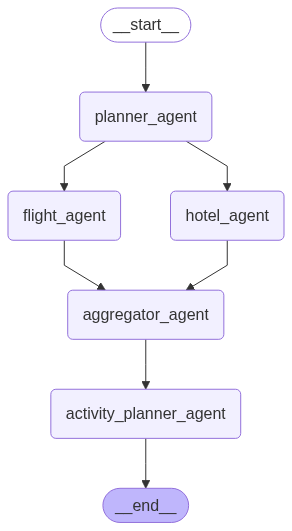

In [155]:
workflow = StateGraph(TripState)


workflow.add_node("planner_agent", planner_agent)
workflow.add_node("flight_agent", flight_agent)
workflow.add_node("hotel_agent", hotel_agent) 
workflow.add_node("aggregator_agent", aggregator_agent) 
workflow.add_node("activity_planner_agent", activity_planner_agent)


workflow.add_edge(START, "planner_agent")

workflow.add_edge("planner_agent", "flight_agent")
workflow.add_edge("planner_agent", "hotel_agent")

workflow.add_edge(["flight_agent", "hotel_agent"], "aggregator_agent")

workflow.add_edge("aggregator_agent", "activity_planner_agent")
workflow.add_edge("activity_planner_agent", END)


app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [156]:
user_query = "I want to plan a 5-day trip to Rome for me and my girlfriend. We are interested in history and food, and my budget is around 1500 euros."
initial_state = {"user_request": user_query}
final_state = app.invoke(initial_state)

print("\n--- FINAL ITINERARY ---")
from pprint import pprint

if final_state.get("final_itinerary"):
    pprint(final_state["final_itinerary"].model_dump())


--- Running Planner Agent ---
-> Structured Plan: destination='Rome' days=5 person=2 budget=1500.0 interests=['history', 'food']
--- Running Hotel Agent ---
--- Calling Hotel Search Tool for Rome for 2 people ---
-> Hotel Info: hotel_name='Grand Royale Hotel' price_per_night=150.0 total_price=600.0 rating=4.5
--- Running Flight Agent ---
--- Calling Flight Search Tool for Rome for 2 people ---
-> Flight Info: airline='Turkish Airlines' price=1500.0 origin='Antalya' destination='Rome'
--- Running Aggregator Agent ---
-> Aggregated Flight Info: airline='Turkish Airlines' price=1500.0 origin='Antalya' destination='Rome'
-> Aggregated Hotel Info: hotel_name='Grand Royale Hotel' price_per_night=150.0 total_price=600.0 rating=4.5
--- Running Activity Planner Agent ---
--- Calling Activity Finder Tool for Rome with interests: ['history', 'food'] ---
-> Final Itinerary Created

--- FINAL ITINERARY ---
{'daily_plans': [{'activities': [{'description': 'Ancient Roman amphitheater.',
             